In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore

from tools.data_loading import get_lincs, get_sirna_screen
from tools.genedisco_datasets import get_crispri_il2_screen
from tools.metrics import primary_dists


# Data Loading

In [74]:
lincs, lincs_genes, cell_lines = get_lincs()

lincs_shuffled = np.copy(lincs)
for cell_line in np.arange(lincs.shape[-1]):
    order = np.arange(lincs.shape[0])
    np.random.shuffle(order)
    lincs_shuffled[:,:,cell_line] = lincs[order,:,cell_line] 

Pulling folder parsed/literature_datasets/L1000


In [75]:
sirna = get_sirna_screen()

Pulling folder parsed/literature_datasets/Muller_HCI-siRNA


## Starting with L2

In [76]:
metric = 'euclidean'
dists= {'real':primary_dists(lincs, metric = metric),
        'shuffled':primary_dists(lincs_shuffled, metric = metric)}

In [98]:
phenotype_KOs = sirna[sirna['gene'].isin(lincs_genes)].copy()
phenotype_vals = phenotype_KOs['value'].values
mygenes = phenotype_KOs['gene'].values

good_KOs = [ko for ko in mygenes if ko in lincs_genes]

In [99]:
THRESH = 1.96
sims = {}
for ntype in ['real','shuffled']:
    #median distances across cell lines
    sim = np.median(dists[ntype],axis = 0)
    #z-score filter to make a sparse-graph
    zscores = zscore(sim, axis = 1)
    sim[zscores>-THRESH] = 0
    sim[zscores<=-THRESH] = 1
    #remove self edges
    sim[np.diag_indices(sim.shape[0])] = 0
    sim = pd.DataFrame(data = sim, index = lincs_genes, columns = lincs_genes)
    sim = sim.loc[good_KOs,good_KOs]
    #make rows sum to 1
    sim /= sim.sum(axis = 1).values[:,None]
    sims[ntype] = sim

Text(0, 0.5, "Absolute phenotypic difference\nbetween node and it's neighbour")

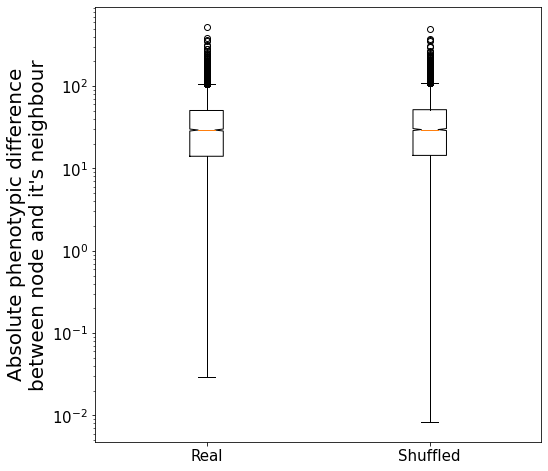

In [106]:
boxes = [
    abs(phenotype_vals-sims['real'].values.dot(phenotype_vals)),
    abs(phenotype_vals-sims['shuffled'].values.dot(phenotype_vals))
    ]
fig, ax = plt.subplots(1, figsize = (8,8))
bplot = ax.boxplot(boxes, notch = True)
ax.set_yscale('log')
ax.set_xticklabels(['Real','Shuffled'])
ax.tick_params(labelsize = 15)
ax.set_ylabel("Absolute phenotypic difference\nbetween node and it's neighbour", size = 20)

## Loading up DEG contingency data

In [107]:
dists = {}
for ntype in ['real','shuffled']:
    dists[ntype] = {}
    for name, dset in zip(['OR','p'],[f'LINCS_{ntype}_fisher_OR.npy',f'LINCS_{ntype}_fisher_p.npy']):
        dists[ntype][name] = np.load(dset)

    #dists[ntype]['p'][dists[ntype]['OR']<1] = 1

## Creating a graph

In [115]:
from scipy.stats import combine_pvalues
numkos = 5002
eps = 1e-20
#aggregated_pvals = {ntype: np.apply_along_axis(lambda x: combine_pvalues(x)[1], 0, dists[ntype]['p'][:,:numkos,:numkos]+eps) for ntype in ['real','shuffled']}
aggregated_pvals = {ntype: np.median(dists[ntype]['p'][:,:numkos,:numkos], axis = 0) for ntype in ['real', 'shuffled']}

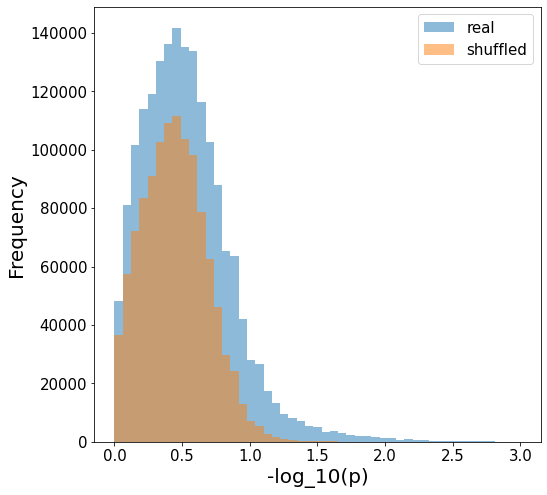

In [116]:
indices = np.triu_indices(aggregated_pvals['real'].shape[0], 1)
fig, ax = plt.subplots(1, figsize = (8,8))
for ntype in ['real','shuffled']:
    v = -np.log10(aggregated_pvals[ntype])[indices]
    h = ax.hist(
        v[v>0], 
        bins = np.linspace(0, 3, 50), 
        label = ntype,
        alpha = 0.5
        )

ax.tick_params(labelsize = 15)
ax.set_xlabel(f"-log_10(p)", size = 20)
ax.set_ylabel('Frequency', size = 20)
ax.legend(prop = {'size': 15})

In [117]:
THRESH = np.min(np.max(-np.log10(aggregated_pvals[ntype]), axis = 1))
adj = {ntype: -np.log10(aggregated_pvals[ntype]) for ntype in ['real','shuffled']}
for ntype in ['real','shuffled']:
    adj[ntype][adj[ntype]<THRESH] = 0
    adj[ntype][adj[ntype]>=THRESH] = 1

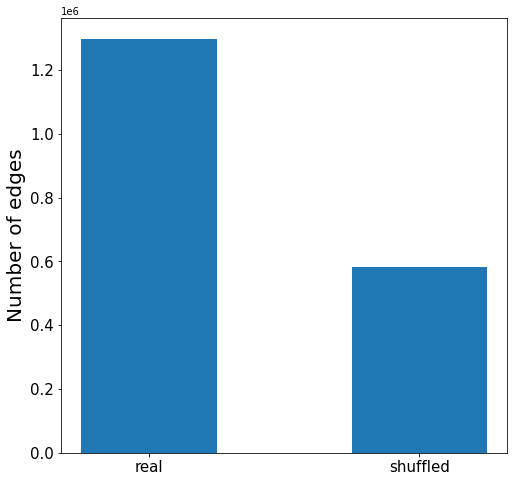

In [118]:
bars = [np.sum(adj[ntype]>0) for ntype in ['real','shuffled']]
fig, ax = plt.subplots(1, figsize = (8,8))
ax.bar([0,1], bars, width = 0.5)
ax.set_xticks([0,1])
ax.set_xticklabels(['real','shuffled'])
ax.set_ylabel("Number of edges", size = 20)
ax.tick_params(labelsize = 15)

Text(0, 0.5, 'Node Degree')

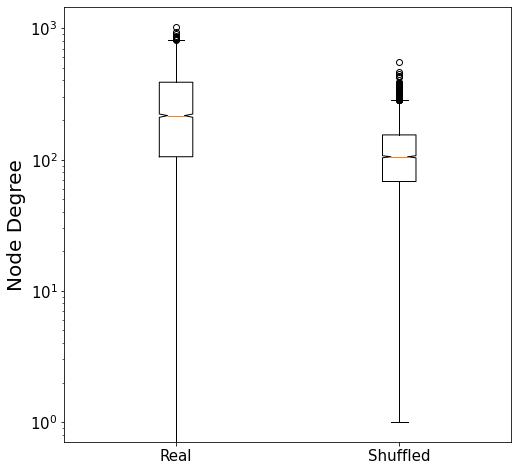

In [119]:
boxes = [adj['real'].sum(axis = 1),adj['shuffled'].sum(axis = 1)]
fig, ax = plt.subplots(1, figsize = (8,8))
bplot = ax.boxplot(boxes, notch = True)
ax.set_yscale('log')
ax.set_xticklabels(['Real','Shuffled'])
ax.tick_params(labelsize = 15)
ax.set_ylabel("Node Degree", size = 20)

In [120]:
phenotype_KOs = sirna[sirna['gene'].isin(lincs_genes[:numkos])].copy()
phenotype_vals = phenotype_KOs['value'].values
mygenes = phenotype_KOs['gene'].values

good_KOs = np.where([ko in mygenes for ko in lincs_genes[:numkos]])[0]
for ntype in ['real','shuffled']:
    adj[ntype] = adj[ntype][good_KOs,:]
    adj[ntype] = adj[ntype][:,good_KOs]
'''
crispr_il2 = get_crispri_il2_screen()
kos = []
vals = []
for ko, val in crispr_il2.items():
    kos.append(ko)
    vals.append(val.detach().item())
vals = np.array(vals).astype('float')

phenotype_KOs = np.where([item in lincs_genes[:numkos] for item in kos])[0]
phenotype_vals = vals[phenotype_KOs]
mygenes = [kos[idx] for idx in phenotype_KOs]

good_KOs = np.where([ko in mygenes for ko in lincs_genes[:numkos]])[0]
for ntype in ['real','shuffled']:
    adj[ntype] = adj[ntype][good_KOs,:]
    adj[ntype] = adj[ntype][:,good_KOs]
'''

"\ncrispr_il2 = get_crispri_il2_screen()\nkos = []\nvals = []\nfor ko, val in crispr_il2.items():\n    kos.append(ko)\n    vals.append(val.detach().item())\nvals = np.array(vals).astype('float')\n\nphenotype_KOs = np.where([item in lincs_genes[:numkos] for item in kos])[0]\nphenotype_vals = vals[phenotype_KOs]\nmygenes = [kos[idx] for idx in phenotype_KOs]\n\ngood_KOs = np.where([ko in mygenes for ko in lincs_genes[:numkos]])[0]\nfor ntype in ['real','shuffled']:\n    adj[ntype] = adj[ntype][good_KOs,:]\n    adj[ntype] = adj[ntype][:,good_KOs]\n"

In [121]:
arrayed_phenotype_vals = abs(phenotype_vals[:,None] - phenotype_vals[None:])

Text(0, 0.5, 'Absolute phenotypic difference\nbetween connected nodes')

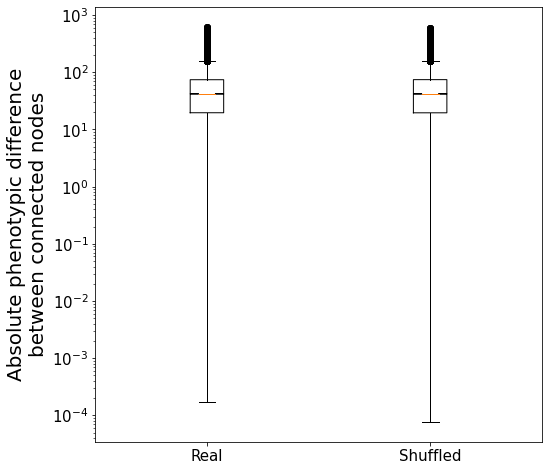

In [122]:
indices = np.triu_indices(adj['real'].shape[0],1)
boxes = [arrayed_phenotype_vals[indices][adj['real'][indices] == 1],arrayed_phenotype_vals[indices][adj['shuffled'][indices] == 1]]
fig, ax = plt.subplots(1, figsize = (8,8))
bplot = ax.boxplot(boxes, notch = True)
ax.set_yscale('log')
ax.set_xticklabels(['Real','Shuffled'])
ax.tick_params(labelsize = 15)
ax.set_ylabel("Absolute phenotypic difference\nbetween connected nodes", size = 20)

<ipython-input-133-5666fdbdf34d>:2: RuntimeWarning: invalid value encountered in true_divide
  abs(phenotype_vals - (adj['real']/adj['real'].sum(axis = 1)[:,None]).dot(phenotype_vals)),


Text(0, 0.5, "Absolute phenotypic difference\nbetween node and it's neighbour")

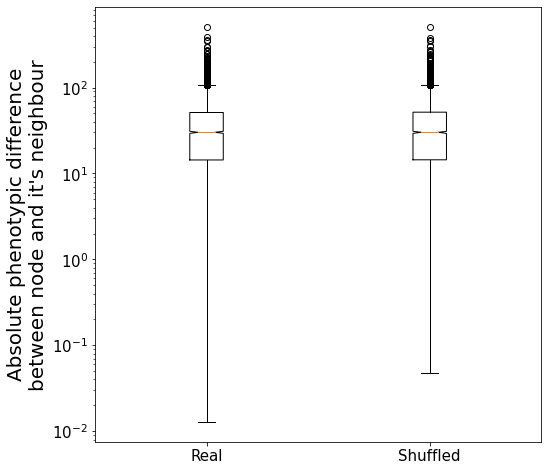

In [133]:
boxes = [
    abs(phenotype_vals - (adj['real']/adj['real'].sum(axis = 1)[:,None]).dot(phenotype_vals)),
    abs(phenotype_vals - (adj['shuffled']/adj['shuffled'].sum(axis = 1)[:,None]).dot(phenotype_vals))
    ]
for idx, item in enumerate(boxes):
    item[np.isnan(item)] = np.median(item[~np.isnan(item)])
    boxes[idx] = item
fig, ax = plt.subplots(1, figsize = (8,8))
bplot = ax.boxplot(boxes, notch = True)
ax.set_yscale('log')
ax.set_xticklabels(['Real','Shuffled'])
ax.tick_params(labelsize = 15)
ax.set_ylabel("Absolute phenotypic difference\nbetween node and it's neighbour", size = 20)